In [1]:
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from jax import disable_jit, random
from numpyro.infer import HMC, MCMC, NUTS, DiscreteHMCGibbs, HMCGibbs, Predictive
from numpyro.util import control_flow_prims_disabled, optional


def model(probs, locs):
    c = numpyro.sample("c", dist.Categorical(probs))
    numpyro.sample("x", dist.Normal(locs[c], jnp.sqrt(0.1)))


probs = jnp.array([0.15, 0.3, 0.3, 0.25])
locs = jnp.array([-2, 0, 2, 4])
predictive = Predictive(model, {}, num_samples=int(1e7), return_sites=["x"])
actual_samples = predictive(random.PRNGKey(1), probs, locs)["x"]

In [2]:
%%time
inner_kernel = NUTS(model)
kernel = DiscreteHMCGibbs(NUTS(model), modified=True)
mcmc = MCMC(kernel, 1000, int(1e6), progress_bar=False)
mcmc.run(random.PRNGKey(0), probs, locs)
mcmc.print_summary()
x_samples = mcmc.get_samples()["x"]
assert abs(jnp.mean(x_samples) - 1.3) < 0.1
assert abs(jnp.var(x_samples) - 4.36) < 0.5


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         c      1.66      1.00      2.00      0.00      3.00    551.24      1.00
         x      1.33      2.02      1.71     -2.04      4.33    564.43      1.00

CPU times: user 9.58 s, sys: 144 ms, total: 9.72 s
Wall time: 9.59 s


In [3]:
%%time
from numpyro.infer.mixed_hmc import MixedHMC

inner_kernel = HMC(model, step_size=0.6, adapt_step_size=False, trajectory_length=1.2)
kernel = MixedHMC(inner_kernel, num_trajectories=20)
mcmc = MCMC(kernel, 1000, int(1e6), progress_bar=False)
debug = False
with optional(debug, disable_jit()), optional(debug, control_flow_prims_disabled()):
    mcmc.run(random.PRNGKey(0), probs, locs)
mcmc.print_summary()
x_samples = mcmc.get_samples()["x"]
assert abs(jnp.mean(x_samples) - 1.3) < 0.1
assert abs(jnp.var(x_samples) - 4.36) < 0.5


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         c      1.66      1.01      2.00      0.00      3.00   7087.89      1.00
         x      1.33      2.05      1.70     -2.05      4.34   7262.08      1.00

CPU times: user 25.5 s, sys: 65.7 ms, total: 25.5 s
Wall time: 25.5 s


In [5]:
%%time
from numpyro.infer.mixed_hmc import MixedHMCGibbs

kernel = MixedHMCGibbs(NUTS(model), num_trajectories=20, modified=False)
mcmc = MCMC(kernel, 10000, int(1e6), progress_bar=False)
debug = False
with optional(debug, disable_jit()), optional(debug, control_flow_prims_disabled()):
    mcmc.run(random.PRNGKey(2), probs, locs)
mcmc.print_summary()
x_samples = mcmc.get_samples()["x"]
assert abs(jnp.mean(x_samples) - 1.3) < 0.1
assert abs(jnp.var(x_samples) - 4.36) < 0.5


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         c      1.66      0.99      2.00      0.00      3.00  17384.34      1.00
         x      1.31      2.03      1.58     -1.99      4.48  18015.06      1.00

CPU times: user 44 s, sys: 37.9 ms, total: 44 s
Wall time: 43.9 s


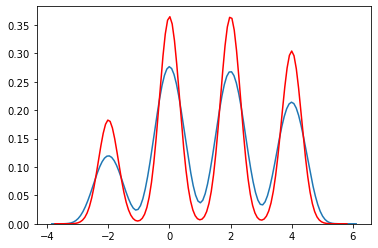

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.kdeplot(x_samples.reshape(-1).copy())
sns.kdeplot(actual_samples.copy(), color="r");